# Cluster Level Thresholding

In [1]:
import mne
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
#load mat from path= "D:\Neuroinformatics Course\Brain Signal Project\code\all_TF.mat"
mat = sio.loadmat('D:/Neuroinformatics Course/Brain Signal Project/code/all_TF.mat')
# mne.stats.permutation_cluster_test
data = mat['storeAllTF']
healthy_ind = np.array([1,12,18,19,20,21,26,37,40,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,22])-1
schizo_ind = np.array([23,24,25,27,28,29,30,31,32,33,34,35,36,38,39])-1
#divide data in healthy and szhizo
healthy_data = data[healthy_ind]
schizo_data = data[schizo_ind]
X = [healthy_data, schizo_data]

threshold = 6.0
F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
    X,
    out_type="mask",
    n_permutations=100,
    # threshold=threshold,
    tail=0,
    seed=np.random.default_rng(seed=8675309),
)

print(F_obs.shape,len(clusters),cluster_p_values.shape,H0.shape)


Using a threshold of 4.098172
stat_fun(H1): min=1.618306881630271e-10 max=15.090009901487527
Running initial clustering …
Found 77 clusters


C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_16860\3702531443.py:18: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
d:\Neuroinformatics Course\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 99/99 [00:02<00:00,   36.28it/s]


(30, 3072) 77 (77,) (100,)


False


Text(0.5, 1.0, 'Power (FCz)')

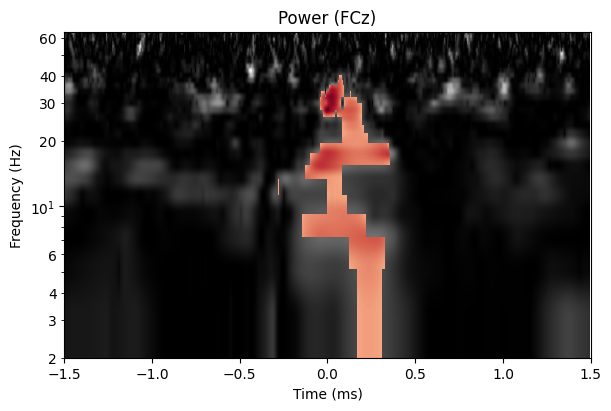

In [2]:
evoked_power_1 = healthy_data.mean(axis=0)
evoked_power_2 = schizo_data.mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
signs = np.sign(evoked_power_contrast)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout="constrained")
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.03:
        F_obs_plot[c] = F_obs[c] * signs[c]
print(np.all(np.isnan(F_obs_plot)))
min_freq = 2
max_freq = 64
num_frex = 30
freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
times = np.linspace(-1.5, 1.5, 3072)
ax.imshow(
    F_obs,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="gray",
)
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(
    F_obs_plot,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    vmin=-max_F,
    vmax=max_F,
)
ax.set_yscale("log")
# ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(plt.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 1)))
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Power (FCz)")

# Connectivity

## PLI based connectivity

In [3]:
import mne_connectivity
import pandas as pd
columnfile = pd.read_csv('../archive/columnLabels.csv')
# for i in range(1,2):
i=1
path = f'../archive/{i}.csv/{i}.csv'
with open(path, newline='') as csvfile:
    subj_i = pd.read_csv(csvfile, delimiter=',',header=None)
    #add column names
    subj_i.columns = columnfile.columns

ntrials,nelec,npnts = 100, 64, 3072
electrodes = columnfile.columns[4:-6].tolist()
data_conn = np.zeros((ntrials,nelec,npnts))
temp = subj_i[np.logical_and(subj_i['subject']==1 , subj_i['condition']==1)]
for i in range(ntrials):
    for j in range(nelec):
        data_conn[i,j,:] = temp[electrodes[j]][temp['trial']==i+1].values
method = ["pli", "wpli", "dpli"]
conn = mne_connectivity.spectral_connectivity_epochs(
        data,
        method=method,
        sfreq=1024,
        fmin=15, #from above thresholded TF plot ~ roughly the beta freq band
        fmax=33,
    )

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 435 connections
    using t=0.000s..2.999s for estimation (3072 points)
    frequencies: 15.0Hz..33.0Hz (55 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI, WPLI, DPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cr

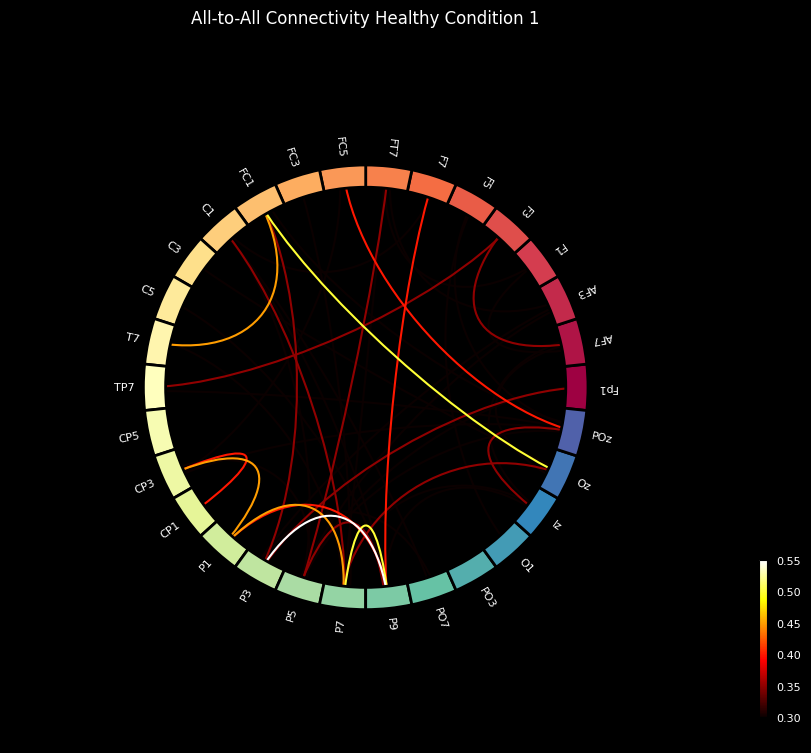

(<Figure size 800x800 with 2 Axes>,
 <PolarAxes: title={'center': 'All-to-All Connectivity Healthy Condition 1'}>)

In [6]:
# conn[0].get_data()[:,0].reshape(30,30)
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout
# fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))

plot_connectivity_circle(
    conn[0].get_data()[:,0].reshape(30,30),
    n_lines=20,
    node_names=electrodes[:30],
    title="Connectivity for Healthy Control"
)

# plot_connectivity_circle(
#     conn[1].get_data()[:,0].reshape(30,30),
#     n_lines=20,
#     node_names=electrodes[:30],
#     title="All-to-All Connectivity Healthy Condition 1",
#     ax=ax2
# )
# plt.show()
# plot_connectivity_circle(
#     conn[2].get_data()[:,0].reshape(30,30),
#     n_lines=20,
#     node_names=electrodes[:30],
#     title="All-to-All Connectivity Healthy Condition 1",
#     ax=ax3
# )
# plt.show()

## Coherence Based Connectivity

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=0.000s..2.999s for estimation (3072 points)
    frequencies: 2.0Hz..512.0Hz (1531 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross

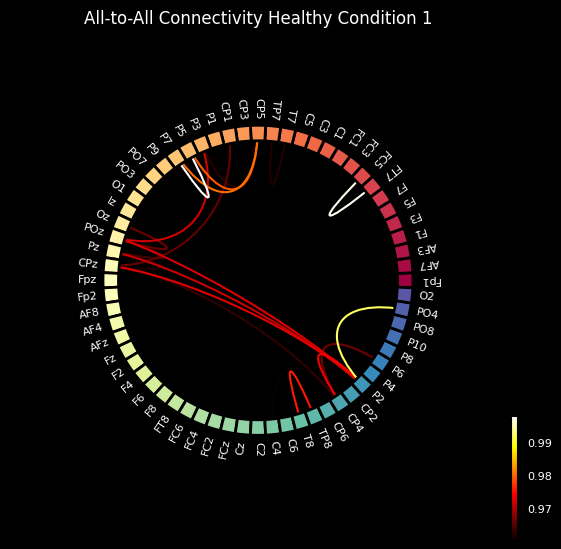

In [5]:
conn_res = mne_connectivity.spectral_connectivity_epochs(data_conn, names=electrodes,sfreq=1024)
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout
fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))
plot_connectivity_circle(
    conn_res.get_data()[:,0].reshape(64,64),
    n_lines=20,
    node_names=electrodes,
    title="All-to-All Connectivity Healthy Condition 1",
    ax=ax,
)
fig.tight_layout()